Group 61 Members: 
1. Arpita Singh – 2024AA05027 - 100% contribution 
2. Koel Banerjee – 2024AB05139 -100% contribution 
3. Sachit Pandey – 2024AA05023 -100% contribution 
4. Boji Harika - 2024AA05343 -100% contribution 
5. Parepalli Tejaswini - 2024AA05566 -100% contribution 

Importing the required Libraries
---

In [2]:
import os
import shutil
import glob
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import mlflow

DATASET REBUILDING PIPELINE
---

This section prepares the PetImages dataset for machine learning by organizing raw cat and dog images into structured train, validation, and test sets. First, all image paths are collected from the raw directory and then split using an 80-10-10 ratio, ensuring balanced distribution for both classes. The training set is used to learn model parameters, the validation set helps tune hyperparameters and detect overfitting, and the test set provides an unbiased final performance evaluation. Each image is copied into its respective split folder with a class-based prefix (cat_ or dog_) to avoid filename collisions and maintain clear labeling. This preprocessing step ensures a clean, consistent dataset pipeline needed for reliable model training and evaluation.

In [ ]:
RAW_DATA_PATH = "archive/PetImages"

os.makedirs("data/train", exist_ok=True)
os.makedirs("data/val", exist_ok=True)
os.makedirs("data/test", exist_ok=True)

cats = glob.glob(os.path.join(RAW_DATA_PATH, "Cat", "*.jpg"))
dogs = glob.glob(os.path.join(RAW_DATA_PATH, "Dog", "*.jpg"))

print("Cats:", len(cats))
print("Dogs:", len(dogs))

# Split cats: 80% train, 10% val, 10% test
train_cats, temp_cats = train_test_split(cats, test_size=0.2, random_state=42)
val_cats, test_cats = train_test_split(temp_cats, test_size=0.5, random_state=42)

# Split dogs: 80% train, 10% val, 10% test
train_dogs, temp_dogs = train_test_split(dogs, test_size=0.2, random_state=42)
val_dogs, test_dogs = train_test_split(temp_dogs, test_size=0.5, random_state=42)

# Function to copy images with a label prefix (cat_ / dog_)
def copy_files(files, dest, label):
    for f in files:
        base = os.path.basename(f)
        new_name = f"{label}_{base}"   
        try:
            shutil.copy(f, os.path.join(dest, new_name))
        except:
            pass

copy_files(train_cats, "data/train", "cat")
copy_files(val_cats,   "data/val",   "cat")
copy_files(test_cats,  "data/test",  "cat")

copy_files(train_dogs, "data/train", "dog")
copy_files(val_dogs,   "data/val",   "dog")
copy_files(test_dogs,  "data/test",  "dog")

print("Dataset rebuilt correctly.")

Cats: 12499
Dogs: 12499
Dataset rebuilt correctly.


This part of the code is used to verify that the dataset has been correctly rebuilt by counting the number of images present in each split-train, validation, and test. After copying the cat and dog images into their respective folders, os.listdir() retrieves all file names within each directory, and len() calculates how many images are present. Printing the sizes helps confirm whether the splitting ratio (such as 80-10-10) has been applied correctly and whether any images were missed or corrupted during the copying process. This simple validation step ensures the dataset structure is accurate before beginning model training.

In [6]:
print("Train size:", len(os.listdir("data/train")))
print("Val size:", len(os.listdir("data/val")))
print("Test size:", len(os.listdir("data/test")))

Train size: 19998
Val size: 2500
Test size: 2500


Loading, Labeling, and Transforming Cat/Dog Images
---
This custom CatsDogsDataset class prepares image data for PyTorch by loading cat and dog images from a directory and assigning labels based on their filenames. The class stores all image names during initialization and uses the __getitem__ method to read each image, convert it to RGB, apply optional transformations such as resizing or normalization, and return both the processed image and its label- 0 for cats and 1 for dogs. The label extraction is based on the prefix added during dataset rebuilding (cat_ / dog_), ensuring correct class mapping. The __len__ method returns the total number of samples, enabling PyTorch’s DataLoader to iterate efficiently. This structure makes the dataset compatible with deep learning pipelines and allows for automatic batching, shuffling, and preprocessing during training.

In [7]:
class CatsDogsDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.images = os.listdir(img_dir)
        self.transform = transform

    def __getitem__(self, idx):
        img_name = self.images[idx]

        if img_name.startswith("cat"):
            label = 0
        else:
            label = 1

        image = Image.open(os.path.join(self.img_dir, img_name)).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.images)

Visualizing Random Samples from the Dataset
---
This section defines a helper function to display a set of random images from the dataset along with their predicted labels (Cat or Dog). By selecting random indices and plotting the corresponding images, it provides a quick visual check to ensure that images are loaded correctly, labels are assigned properly, and transformations (like converting to tensors) have been applied as expected. This visualization step is important before training, as it helps verify dataset quality and catch issues such as corrupted images, wrong labels, or preprocessing errors.


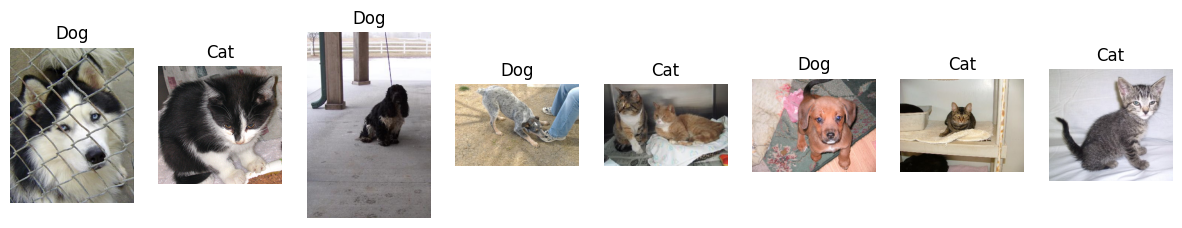

In [8]:
import random

def show_random_sample(dataset, n=8):
    plt.figure(figsize=(15, 3))
    indices = random.sample(range(len(dataset)), n)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Cat" if label == 0 else "Dog")

sample_ds = CatsDogsDataset("data/train", transform=transforms.ToTensor())
show_random_sample(sample_ds)

Applying Data Augmentation and Creating Train/Val/Test DataLoaders
---
In this section, different image transformations are defined for training and testing to prepare the dataset for model learning. The training pipeline includes resizing, random flips, and slight rotations to perform data augmentation, helping the model generalize better. For validation and testing, only resizing and tensor conversion are applied to keep the evaluation consistent. These transformed datasets are then wrapped into DataLoaders, which handle batching, shuffling (for training), and efficient loading of images during training and evaluation.

In [9]:
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds = CatsDogsDataset("data/train", transform=train_tf)
val_ds   = CatsDogsDataset("data/val",   transform=test_tf)
test_ds  = CatsDogsDataset("data/test",  transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

Building and Initializing the ResNet18 Transfer Learning Model
---
In this section, a pre-trained ResNet18 model is loaded and used for transfer learning by freezing all backbone layers so only the final fully connected block is trained. A new classifier head is added with linear layers, ReLU activation, and dropout to adapt the model for two classes: cats and dogs. The model is then moved to the available device (GPU or CPU), and the loss function and optimizer are set up using CrossEntropyLoss for classification and Adam to optimize only the new classifier layers for efficient fine-tuning.

In [10]:
def build_model(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, num_classes)
    )
    return model

device = "cuda" if torch.cuda.is_available() else "cpu"
model = build_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

4.2%

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\sachi/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


Training and Validating the Model with MLflow Tracking
---
This section defines the training loop that handles both model optimization and performance monitoring. Each epoch includes a forward pass, loss computation, backpropagation, and parameter updates for the training set, followed by an evaluation phase on the validation set using torch.no_grad(). During training, key metrics such as loss and accuracy for both train and validation sets are logged to MLflow for experiment tracking. The model checkpoint with the lowest validation loss is saved to ensure the best-performing version is preserved. This structured pipeline ensures reproducible training, systematic evaluation, and automatic experiment logging.

In [11]:
def train_model(epochs=3):
    # Fix MLflow: end any active run first
    if mlflow.active_run() is not None:
        mlflow.end_run()

    mlflow.start_run()   # start a fresh run

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_correct = 0
        total_samples = 0

        # TRAINING LOOP
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            preds = model(imgs)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_correct += (preds.argmax(dim=1) == labels).sum().item()
            total_samples += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = total_correct / total_samples

        train_losses.append(avg_train_loss)
        mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)

        # VALIDATION LOOP
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)

                preds = model(imgs)
                loss = criterion(preds, labels)

                total_val_loss += loss.item()
                total_val_correct += (preds.argmax(dim=1) == labels).sum().item()
                total_val_samples += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = total_val_correct / total_val_samples

        val_losses.append(avg_val_loss)
        mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # SAVE BEST CHECKPOINT
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print("Saving new best checkpoint")

            os.makedirs("artifacts", exist_ok=True)
            torch.save(model.state_dict(), "artifacts/best_model.pt")
            mlflow.log_artifact("artifacts/best_model.pt")

    mlflow.end_run()

    return train_losses, val_losses

In [12]:
train_losses, val_losses = train_model(epochs=3)

2026/02/13 23:28:56 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/13 23:28:56 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/13 23:28:56 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/13 23:28:56 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/13 23:28:56 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/13 23:28:56 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/13 23:28:56 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/13 23:28:57 INFO mlflow.store.db.utils: Updating database tables
2026/02/13 23:28:57 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/13 23:28:57 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/13 23:28:57 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/02/13 23:2

Epoch 1/3 | Train Loss: 0.1149 | Train Acc: 0.9524 | Val Loss: 0.0811 | Val Acc: 0.9628
Saving new best checkpoint
Epoch 2/3 | Train Loss: 0.0903 | Train Acc: 0.9640 | Val Loss: 0.1252 | Val Acc: 0.9548
Epoch 3/3 | Train Loss: 0.0784 | Train Acc: 0.9689 | Val Loss: 0.0797 | Val Acc: 0.9684
Saving new best checkpoint


Visualizing Training and Validation Loss Across Epochs
---
This section plots the training and validation loss curves to help understand how the model learns over each epoch. The training loss typically decreases as the model updates its parameters, while the validation loss helps indicate whether the model is generalizing well to unseen data. By comparing both curves on the same graph, you can easily detect issues such as underfitting, overfitting, or instability during training.

In the displayed graph, the training loss shows a steady decrease over the epochs, indicating that the model is learning effectively from the training data. The validation loss, however, follows a different pattern: it initially increases and then drops significantly. This suggests that the model may have required one or two epochs to stabilize due to factors like random weight initialization or data augmentation randomness. The final decrease in both curves is a positive sign, showing that the model is improving generalization by the last epoch. More epochs would provide a clearer trend, helping confirm whether the model converges smoothly or requires further tuning.

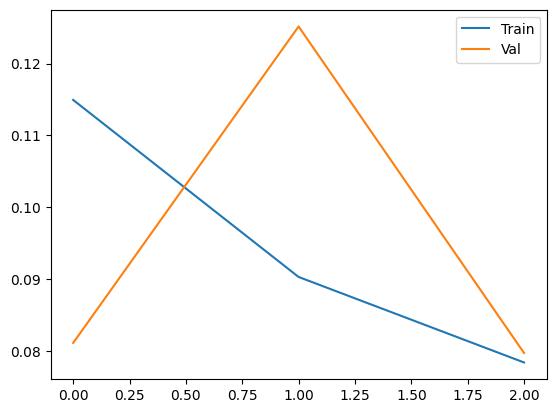

In [13]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.legend()
plt.show()

Generating Predictions on the Test Set
---
In this section, the trained model is switched to evaluation mode and used to generate predictions for all images in the test dataset. By disabling gradient calculations with torch.no_grad(), the process becomes faster and memory-efficient. For each batch, the model’s output logits are converted into class predictions using argmax, and both predictions and true labels are stored for later evaluation. This step prepares the necessary data to compute final performance metrics such as accuracy, precision, recall, F1-score, and confusion matrix.

In [14]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        preds = model(imgs)
        all_preds.extend(torch.argmax(preds, dim=1).cpu().tolist())
        all_labels.extend(labels.tolist())

Confusion Matrix for Model Performance on the Test Set
---
This section visualizes the model’s classification performance using a confusion matrix, which summarizes how many images were correctly or incorrectly predicted for each class. The rows represent the true labels (Cat or Dog), and the columns represent the predicted labels. This visualization helps identify patterns such as class imbalance, misclassification trends, and overall prediction quality that accuracy alone may not reveal.

The confusion matrix shows that the model performs exceptionally well on both classes. For Cats, 1242 images are correctly classified, with only 8 misclassified as Dogs. For Dogs, 1187 are correctly predicted, while 63 are misclassified as Cats. The errors are minimal compared to the total sample size, indicating strong overall generalization. The model is slightly more accurate on Cats than Dogs, but both classes exhibit high precision and recall. Such results suggest that the transfer-learning-based ResNet18 model is highly effective for this dataset.

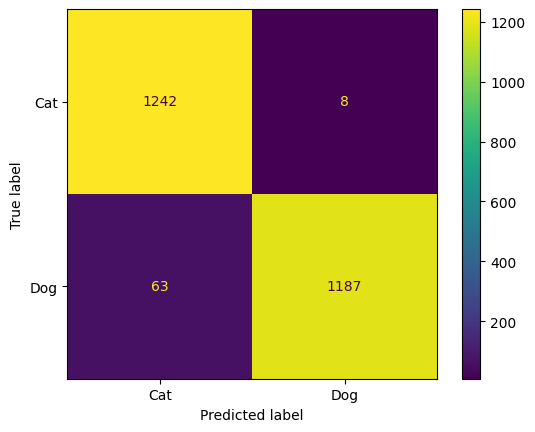

In [15]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Cat", "Dog"])
disp.plot()
plt.show()